# Import all Packages

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data Preparation
1. We will be using the model `vit_base_patch16_224`
  * This means all image need to be reshaped to (224,224)
2. In training, we are using data augmentation process: `RandomHorizontalFlip`. 
  * It is optional step
  *  It randomly flips an input image horizontally
  * It  artificially increase the size and diversity of the training dataset
3. We also normalizes the image `transforms.Normalize`
  * This will reduce the scale of image
  * It helps on Faster convergence, better generalization, and numercial stability


In [2]:
# Please download the images from `https://www.kaggle.com/datasets/jr2ngb/cataractdataset` and place in your machine's directory
DATA_DIR = "/Users/premtimsina/Documents/chapter7/dataset/"
CLASSES = ["normal", "cataract", "glaucoma", "retina_disease"]

data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append([img_path, class_idx])

df = pd.DataFrame(data, columns=["image_path", "label"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CataractDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CataractDataset(train_df["image_path"].values, train_df["label"].values, transform=train_transforms)
test_dataset = CataractDataset(test_df["image_path"].values, test_df["label"].values, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



# Let's review our dataloader
1. We are just viewing the image from train_dataloader
2. There is one very important step:
  * matplotlib need the image in [H, W, C]; where dataloader has image of shape [C, H,W]
  * Thus, before plotting we are transposing so that the data is suitable for viewing for matplotlib

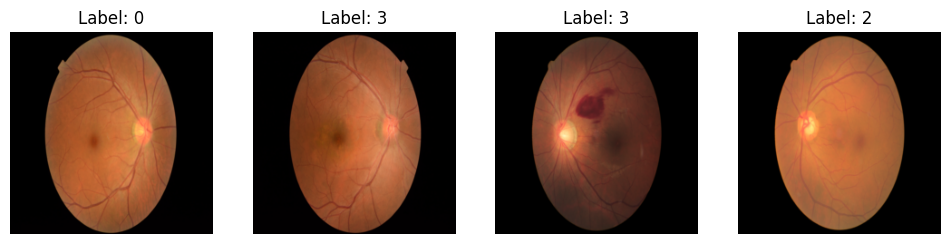

In [6]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and convert a tensor image to numpy array
def imshow(img_tensor):
    img = img_tensor.numpy()
    # transposing
    img = np.transpose(img, (1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Display the images and their labels
fig, axes = plt.subplots(1, len(images), figsize=(12, 12))

for idx, (image, label) in enumerate(zip(images, labels)):
    axes[idx].imshow(imshow(image))
    axes[idx].set_title(f"Label: {label.item()}")
    axes[idx].axis("off")

plt.show()


# Declare the model
1. We are using the pre-trained model from timm
2. If the image is color, 
  * in_chans=3;
3. if image is graysclae, 
  * in_chans=3=1
4. We need to declare, how many classes we have in out dataset: 
  * For our case, it was 4.
  * num_classes=4
5. `pretrained=True`
  * We are mentioning that we want weight of pre-trained model. If you want to train from scratch, you could just mention 
    * pretrained=False

In [8]:
import timm
model = timm.create_model("vit_base_patch16_224", in_chans=3, num_classes=4, pretrained=True)


# Declare the train and test loop
1. In the below code: I am converting output and target into 'cpu'. Somehow my M1 chip is producing the problem. You may not encounter the problem. Thus, this is totally optional step.

In [18]:
def train(model, device, train_loader, optimizer, criterion, epoch, accelerator):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}")

from sklearn.metrics import confusion_matrix, recall_score, precision_score

def test(model, device, test_loader, criterion, accelerator):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            output_cpu = output.to('cpu')
            target_cpu=target.to('cpu')
            pred = output_cpu.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_cpu.view_as(pred)).sum().item()
            
            all_preds.extend(pred.flatten().tolist())
            all_targets.extend(target.flatten().tolist())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Calculate confusion matrix, sensitivity (recall), and specificity
    cm = confusion_matrix(all_targets, all_preds)
    sensitivity = recall_score(all_targets, all_preds, average=None)
    specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)
    
    for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        print(f"Class {i}: Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}")



In [19]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
model, optimizer, criterion = accelerator.prepare(model, optimizer, criterion)





In [22]:


num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(model, device, test_loader, criterion, accelerator)

100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.74it/s]


Epoch: 1, Loss: 0.9448


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_57405/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.1269, Accuracy: 48.76%
Class 0: Sensitivity (Recall): 0.6066, Specificity: 0.3509
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.4643
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan
Class 3: Sensitivity (Recall): 0.3500, Specificity: 0.8056


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 2, Loss: 0.9016
Test Loss: 1.0736, Accuracy: 53.72%
Class 0: Sensitivity (Recall): 0.7049, Specificity: 0.3582
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.5500, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 3, Loss: 0.8900
Test Loss: 1.0879, Accuracy: 58.68%
Class 0: Sensitivity (Recall): 0.9344, Specificity: 0.4300
Class 1: Sensitivity (Recall): 0.4500, Specificity: 0.2500
Class 2: Sensitivity (Recall): 0.1000, Specificity: 0.0000
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.5714


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 4, Loss: 0.8520
Test Loss: 1.2384, Accuracy: 46.28%
Class 0: Sensitivity (Recall): 0.4098, Specificity: 0.2857
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3529
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.7222
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.6667


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 5, Loss: 0.8687
Test Loss: 0.9601, Accuracy: 61.16%
Class 0: Sensitivity (Recall): 0.7869, Specificity: 0.3425
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.4500
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.4444
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 6, Loss: 0.8112
Test Loss: 1.0747, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 0.9016, Specificity: 0.4388
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.2667
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.2500
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 7, Loss: 0.6973
Test Loss: 1.0880, Accuracy: 60.33%
Class 0: Sensitivity (Recall): 0.8033, Specificity: 0.3797
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.4545
Class 2: Sensitivity (Recall): 0.5500, Specificity: 0.3889
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.5000


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 8, Loss: 0.7467


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_57405/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.2283, Accuracy: 52.89%
Class 0: Sensitivity (Recall): 0.5410, Specificity: 0.3529
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.4828
Class 2: Sensitivity (Recall): 0.8000, Specificity: 0.6098
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 9, Loss: 0.7473
Test Loss: 1.2848, Accuracy: 54.55%
Class 0: Sensitivity (Recall): 0.8361, Specificity: 0.3780
Class 1: Sensitivity (Recall): 0.3000, Specificity: 0.1429
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.4444
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.8261


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.72it/s]


Epoch: 10, Loss: 0.7980
Test Loss: 1.0402, Accuracy: 59.50%
Class 0: Sensitivity (Recall): 0.7213, Specificity: 0.3433
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3889
Class 2: Sensitivity (Recall): 0.7000, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.6250


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 11, Loss: 0.6878
Test Loss: 1.1001, Accuracy: 57.85%
Class 0: Sensitivity (Recall): 0.7213, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.4783
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.7500


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 12, Loss: 0.6879


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_57405/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.2598, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 0.9344, Specificity: 0.4519
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3125
Class 2: Sensitivity (Recall): 0.0500, Specificity: 0.0000
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 13, Loss: 0.6774
Test Loss: 1.2294, Accuracy: 49.59%
Class 0: Sensitivity (Recall): 0.4918, Specificity: 0.3617
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.4545
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.6341
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.7273


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 14, Loss: 0.5857
Test Loss: 1.3928, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 0.7869, Specificity: 0.4286
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.3750
Class 2: Sensitivity (Recall): 0.1000, Specificity: 0.6667
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.4286


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 15, Loss: 0.5913
Test Loss: 1.2990, Accuracy: 54.55%
Class 0: Sensitivity (Recall): 0.5082, Specificity: 0.2791
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.4483
Class 2: Sensitivity (Recall): 0.7000, Specificity: 0.5758
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.6875


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 16, Loss: 0.5987
Test Loss: 1.1137, Accuracy: 55.37%
Class 0: Sensitivity (Recall): 0.6885, Specificity: 0.3731
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3529
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.4737
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.7778


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 17, Loss: 0.5024
Test Loss: 1.1910, Accuracy: 66.12%
Class 0: Sensitivity (Recall): 0.7541, Specificity: 0.2069
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.4194
Class 2: Sensitivity (Recall): 0.4500, Specificity: 0.3077
Class 3: Sensitivity (Recall): 0.3500, Specificity: 0.6316


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 18, Loss: 0.4766
Test Loss: 1.3796, Accuracy: 53.72%
Class 0: Sensitivity (Recall): 0.5410, Specificity: 0.2826
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.5484
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5517
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.6667


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 19, Loss: 0.6051
Test Loss: 1.1983, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 0.6885, Specificity: 0.3115
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.3333
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5938
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.8000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 20, Loss: 0.4295
Test Loss: 1.3232, Accuracy: 53.72%
Class 0: Sensitivity (Recall): 0.5574, Specificity: 0.2917
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.5714
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.7143


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 21, Loss: 0.4376
Test Loss: 1.5208, Accuracy: 46.28%
Class 0: Sensitivity (Recall): 0.5410, Specificity: 0.3889
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.5714
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.2500
Class 3: Sensitivity (Recall): 0.4000, Specificity: 0.7714


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 22, Loss: 0.4133
Test Loss: 1.4732, Accuracy: 54.55%
Class 0: Sensitivity (Recall): 0.6393, Specificity: 0.3036
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.4615
Class 2: Sensitivity (Recall): 0.5500, Specificity: 0.6207
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.8000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 23, Loss: 0.4382
Test Loss: 1.5196, Accuracy: 47.11%
Class 0: Sensitivity (Recall): 0.5246, Specificity: 0.3043
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.5238
Class 2: Sensitivity (Recall): 0.2000, Specificity: 0.2000
Class 3: Sensitivity (Recall): 0.5500, Specificity: 0.7755


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 24, Loss: 0.3861
Test Loss: 1.4471, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 0.6230, Specificity: 0.2963
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.4583
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5517
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.6429


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 25, Loss: 0.2717
Test Loss: 1.3845, Accuracy: 61.16%
Class 0: Sensitivity (Recall): 0.6721, Specificity: 0.3167
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.3000
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.4545
Class 3: Sensitivity (Recall): 0.3500, Specificity: 0.6316


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 26, Loss: 0.4292
Test Loss: 1.2562, Accuracy: 42.98%
Class 0: Sensitivity (Recall): 0.3934, Specificity: 0.3514
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.4583
Class 2: Sensitivity (Recall): 0.7000, Specificity: 0.7586
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.5000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 27, Loss: 0.4134
Test Loss: 1.4674, Accuracy: 52.89%
Class 0: Sensitivity (Recall): 0.7049, Specificity: 0.3768
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3529
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.4444
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.8077


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 28, Loss: 0.3746
Test Loss: 1.3833, Accuracy: 49.59%
Class 0: Sensitivity (Recall): 0.6066, Specificity: 0.3273
Class 1: Sensitivity (Recall): 0.3000, Specificity: 0.2500
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5938
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.8462


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 29, Loss: 0.3730
Test Loss: 1.4943, Accuracy: 54.55%
Class 0: Sensitivity (Recall): 0.6721, Specificity: 0.4225
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.4286
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.4000
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.7500


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 30, Loss: 0.2675
Test Loss: 1.9772, Accuracy: 53.72%
Class 0: Sensitivity (Recall): 0.5902, Specificity: 0.3793
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.4000
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.4667
Class 3: Sensitivity (Recall): 0.3000, Specificity: 0.7391


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 31, Loss: 0.4079
Test Loss: 1.2920, Accuracy: 55.37%
Class 0: Sensitivity (Recall): 0.7049, Specificity: 0.3175
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3529
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.5556
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.9286


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 32, Loss: 0.2767
Test Loss: 1.5353, Accuracy: 56.20%
Class 0: Sensitivity (Recall): 0.6393, Specificity: 0.2909
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.4118
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5185
Class 3: Sensitivity (Recall): 0.3000, Specificity: 0.7273


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.69it/s]


Epoch: 33, Loss: 0.2330
Test Loss: 1.7612, Accuracy: 42.98%
Class 0: Sensitivity (Recall): 0.3934, Specificity: 0.3684
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.4167
Class 2: Sensitivity (Recall): 0.3500, Specificity: 0.6111
Class 3: Sensitivity (Recall): 0.3500, Specificity: 0.8293


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.69it/s]


Epoch: 34, Loss: 0.3126
Test Loss: 1.4320, Accuracy: 55.37%
Class 0: Sensitivity (Recall): 0.8033, Specificity: 0.3951
Class 1: Sensitivity (Recall): 0.2500, Specificity: 0.4444
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.4783
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.8750


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 35, Loss: 0.2884
Test Loss: 1.7068, Accuracy: 47.93%
Class 0: Sensitivity (Recall): 0.6393, Specificity: 0.4091
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.4783
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.6667
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.8261


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.69it/s]


Epoch: 36, Loss: 0.3131
Test Loss: 1.5639, Accuracy: 58.68%
Class 0: Sensitivity (Recall): 0.8197, Specificity: 0.3827
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.4286
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.6250
Class 3: Sensitivity (Recall): 0.3000, Specificity: 0.4545


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 37, Loss: 0.2329
Test Loss: 1.7258, Accuracy: 46.28%
Class 0: Sensitivity (Recall): 0.4590, Specificity: 0.3488
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.3529
Class 2: Sensitivity (Recall): 0.7000, Specificity: 0.6889
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.8125


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 38, Loss: 0.1365
Test Loss: 2.2104, Accuracy: 48.76%
Class 0: Sensitivity (Recall): 0.4918, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.6250
Class 3: Sensitivity (Recall): 0.4000, Specificity: 0.7333


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.71it/s]


Epoch: 39, Loss: 0.2390
Test Loss: 1.6950, Accuracy: 60.33%
Class 0: Sensitivity (Recall): 0.6393, Specificity: 0.2909
Class 1: Sensitivity (Recall): 0.9500, Specificity: 0.4722
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.4667
Class 3: Sensitivity (Recall): 0.3500, Specificity: 0.5333


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.71it/s]


Epoch: 40, Loss: 0.1917
Test Loss: 1.9211, Accuracy: 59.50%
Class 0: Sensitivity (Recall): 0.8852, Specificity: 0.4130
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.1667
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.2500
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.7778


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.71it/s]


Epoch: 41, Loss: 0.2512
Test Loss: 1.9276, Accuracy: 52.07%
Class 0: Sensitivity (Recall): 0.5410, Specificity: 0.3265
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.4444
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.6389
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.7778


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.71it/s]


Epoch: 42, Loss: 0.2036
Test Loss: 1.8680, Accuracy: 51.24%
Class 0: Sensitivity (Recall): 0.6557, Specificity: 0.3846
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.4737
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.6250
Class 3: Sensitivity (Recall): 0.3000, Specificity: 0.7143


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 43, Loss: 0.2432
Test Loss: 1.4052, Accuracy: 54.55%
Class 0: Sensitivity (Recall): 0.7869, Specificity: 0.4000
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.4211
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.6250
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.8333


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 44, Loss: 0.1992
Test Loss: 1.7148, Accuracy: 52.89%
Class 0: Sensitivity (Recall): 0.7705, Specificity: 0.4337
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.4091
Class 2: Sensitivity (Recall): 0.1000, Specificity: 0.6667
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.8000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 45, Loss: 0.1616
Test Loss: 1.9114, Accuracy: 52.07%
Class 0: Sensitivity (Recall): 0.7869, Specificity: 0.4000
Class 1: Sensitivity (Recall): 0.2500, Specificity: 0.5455
Class 2: Sensitivity (Recall): 0.3500, Specificity: 0.2222
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.8571


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 46, Loss: 0.1832
Test Loss: 2.1460, Accuracy: 55.37%
Class 0: Sensitivity (Recall): 0.7213, Specificity: 0.3889
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.4286
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.2500
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.7500


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 47, Loss: 0.2471
Test Loss: 1.7554, Accuracy: 52.89%
Class 0: Sensitivity (Recall): 0.6557, Specificity: 0.3443
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.5185
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.6190
Class 3: Sensitivity (Recall): 0.1500, Specificity: 0.7500


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 48, Loss: 0.1398
Test Loss: 2.0755, Accuracy: 55.37%
Class 0: Sensitivity (Recall): 0.7869, Specificity: 0.3924
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.4583
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.3750
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.9000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 49, Loss: 0.3330
Test Loss: 1.6170, Accuracy: 50.41%
Class 0: Sensitivity (Recall): 0.5082, Specificity: 0.3542
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.4400
Class 2: Sensitivity (Recall): 0.5500, Specificity: 0.5217
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.8000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 50, Loss: 0.2016
Test Loss: 1.9680, Accuracy: 46.28%
Class 0: Sensitivity (Recall): 0.4262, Specificity: 0.3810
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.4762
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.4583
Class 3: Sensitivity (Recall): 0.3000, Specificity: 0.8235


# Analysis:
1. The loss is decreasing. We need more epoch.

In [ ]:
#